In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pygmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot
from functools import partial

In [3]:
dt.config()

In [4]:
lc = 0.1
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[0], label="down")
    geom.add_physical(p.lines[2], label="up")
    geom.add_physical(p.lines[1], label="right")
    geom.add_physical(p.lines[3], label="left")
    mesh = geom.generate_mesh()

S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
S.get_flat_DPP_weights()

ref_node_coords = S.node_coords

In [5]:
down_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "down")
up_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "up")
down_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "down")
up_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "up")
left_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "left")
right_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "right")
left_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "left")
right_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "right")

print(down_bnd_edges_idx)
print(up_bnd_edges_idx)
print(left_bnd_nodes_idx)
print(right_bnd_nodes_idx)

[0, 12, 15, 18, 21, 24, 27, 30, 33, 3]
[7, 64, 67, 70, 73, 76, 79, 82, 85, 9]
[32, 33, 34, 3, 35, 36, 37, 38, 39, 0, 31]
[1, 2, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [6]:
mu_ = 1.
lambda_ = 10.
gamma_ = 0.5
tau_ = mu_*gamma_
true_curr_node_coords = S.node_coords.copy()
true_curr_node_coords[:, 0] += gamma_*S.node_coords[:, 1]
up_bnd_pos_components = [0]

up_bnd_nodes_pos_x = true_curr_node_coords[up_bnd_nodes_idx, 0]
up_bnd_nodes_pos_y = ref_node_coords[up_bnd_nodes_idx, 1]
up_bnd_pos = np.zeros((len(up_bnd_nodes_idx), 3))
up_bnd_pos[:,0] = up_bnd_nodes_pos_x
up_bnd_pos[:,1] = up_bnd_nodes_pos_y
print(up_bnd_pos)
down_bnd_pos = ref_node_coords[down_bnd_nodes_idx, :]
print(down_bnd_pos)
left_bnd_pos = true_curr_node_coords[left_bnd_nodes_idx, :]
right_bnd_pos = true_curr_node_coords[right_bnd_nodes_idx, :]
print(np.vstack((left_bnd_pos, right_bnd_pos)))

[[1.5 1.  0. ]
 [0.5 1.  0. ]
 [1.4 1.  0. ]
 [1.3 1.  0. ]
 [1.2 1.  0. ]
 [1.1 1.  0. ]
 [1.  1.  0. ]
 [0.9 1.  0. ]
 [0.8 1.  0. ]
 [0.7 1.  0. ]
 [0.6 1.  0. ]]
[[0.  0.  0. ]
 [1.  0.  0. ]
 [0.1 0.  0. ]
 [0.2 0.  0. ]
 [0.3 0.  0. ]
 [0.4 0.  0. ]
 [0.5 0.  0. ]
 [0.6 0.  0. ]
 [0.7 0.  0. ]
 [0.8 0.  0. ]
 [0.9 0.  0. ]]
[[0.4  0.8  0.  ]
 [0.35 0.7  0.  ]
 [0.3  0.6  0.  ]
 [0.5  1.   0.  ]
 [0.25 0.5  0.  ]
 [0.2  0.4  0.  ]
 [0.15 0.3  0.  ]
 [0.1  0.2  0.  ]
 [0.05 0.1  0.  ]
 [0.   0.   0.  ]
 [0.45 0.9  0.  ]
 [1.   0.   0.  ]
 [1.5  1.   0.  ]
 [1.05 0.1  0.  ]
 [1.1  0.2  0.  ]
 [1.15 0.3  0.  ]
 [1.2  0.4  0.  ]
 [1.25 0.5  0.  ]
 [1.3  0.6  0.  ]
 [1.35 0.7  0.  ]
 [1.4  0.8  0.  ]
 [1.45 0.9  0.  ]]


In [7]:
# NOTE: without flatten it does not work properly when concatenating multiple bcs;
# fix this so that flatten is not needed (not intuitive)
#boundary_values = {"0": (up_bnd_nodes_idx, up_bnd_nodes_pos_x),
#                   ":": (down_bnd_nodes_idx, down_bnd_pos)}
bnodes = left_bnd_nodes_idx + right_bnd_nodes_idx + up_bnd_nodes_idx + down_bnd_nodes_idx
bvalues = np.vstack((left_bnd_pos, right_bnd_pos, up_bnd_pos, down_bnd_pos))
boundary_values = {":": (bnodes, bvalues)}
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 1000000.
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
f = np.zeros((num_faces, (embedded_dim-1)))
#f = np.zeros((S.num_nodes, (embedded_dim-1)), dtype=dt.float_dtype)
#curr_node_coords = jnp.full(
#    S.node_coords.shape, jnp.nan, dtype=dt.float_dtype)
obj = ela.obj_linear_elasticity_energy
#obj = ela.obj_linear_elasticity_primal
x0 = S.node_coords.flatten()
# x0 = true_curr_node_coords.flatten()

#unknown_node_coords = S.node_coords.copy()
#unknown_node_coords[up_bnd_nodes_idx , 0] = np.nan
#unknown_node_coords[down_bnd_nodes_idx, :] = np.nan
#unknown_node_coords_flattened = unknown_node_coords.flatten()
#unknown_node_idx = ~np.isnan(unknown_node_coords_flattened)
#x0 = unknown_node_coords_flattened[unknown_node_idx]
#obj = partial(ela.obj_linear_elasticity_dual,
#                          unknown_node_idx=unknown_node_idx)

# traction bcs
primal_vol_left = S.primal_volumes[1][left_bnd_edges_idx]
primal_vol_right = S.primal_volumes[1][right_bnd_edges_idx]
idx_left_right_edges = left_bnd_edges_idx + right_bnd_edges_idx
bnd_tractions_up = np.zeros(len(up_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left = -tau_*np.ones(len(left_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left *= primal_vol_left
#bnd_tractions_left[-1] *= -1
bnd_tractions_right = tau_*np.ones(len(right_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_right *= primal_vol_right
#bnd_tractions_right[-1] *= -1
bnd_tractions_left_right = np.zeros(len(idx_left_right_edges), dtype = dt.float_dtype)
idx_tract_y = up_bnd_edges_idx + idx_left_right_edges
bnd_tractions_y = np.concatenate((bnd_tractions_up, bnd_tractions_left, bnd_tractions_right))
#bnd_tractions_y = np.concatenate((bnd_tractions_left, bnd_tractions_right))

num_edges = S.S[1].shape[0]

ext_forces_coeffs = np.zeros((num_edges, 3), dtype = dt.float_dtype)
ext_forces_coeffs[left_bnd_edges_idx,1] = bnd_tractions_left
ext_forces_coeffs[right_bnd_edges_idx,1] = bnd_tractions_right
#ext_forces_coch_coeffs = np.sum(ext_forces_coeffs*S.primal_edges_vectors, axis=1)
#ext_forces = C.CochainP1(S, ext_forces_coeffs)

boundary_tractions = {'1': (idx_tract_y, bnd_tractions_y),
                     '0': (idx_left_right_edges, bnd_tractions_left_right)}
#obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 'ext_forces': ext_forces_coeffs}
obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values}
#obj_args = {'f': f,
#            'boundary_values': boundary_values,
#            'boundary_tractions': boundary_tractions,
#            'curr_node_coords': curr_node_coords}
#obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 'boundary_tractions': boundary_tractions}

In [8]:
prb = optctrl.OptimizationProblem(dim=len(x0), state_dim=len(x0),objfun=obj)

prb.set_obj_args(obj_args)
sol = prb.solve(x0=x0, ftol_abs=1e-12, ftol_rel=1e-12, maxeval = 20000)
print(prb.last_opt_result)
curr_node_coords = sol.reshape(S.node_coords.shape)
#print(len(sol))
#curr_node_coords = ela.set_displacement_bc(curr_node_coords, boundary_values)
#curr_node_coords_flattened = curr_node_coords.flatten()
#curr_node_coords_flattened = curr_node_coords_flattened.at[jnp.isnan(
#    curr_node_coords_flattened)].set(sol)
#curr_node_coords = curr_node_coords_flattened.reshape(S.node_coords.shape)

1


In [9]:
#print(obj(sol, f, gamma, boundary_values, boundary_tractions))
#print(obj(true_curr_node_coords.flatten(), f, gamma, boundary_values, boundary_tractions))
true_node_coch = C.CochainP0(S, curr_node_coords)
f_coch = C.CochainP2(S, f)
#res = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
forces = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
print(forces.coeffs[down_bnd_edges_idx,:])
#bad_coeffs =np.where(np.abs(res.coeffs[:,1]) > 1e-8)
#print(bad_coeffs)

[[-6.95339314e-10  1.36709189e-09]
 [ 4.42984701e-09 -6.37217328e-10]
 [-6.31900000e-09  2.57930192e-09]
 [ 4.58085611e-10 -2.66680589e-09]
 [-1.88128145e-09  1.26347735e-09]
 [ 5.88903361e-09 -9.95285561e-09]
 [-4.72610803e-09 -3.45704525e-09]
 [-2.89763206e-10 -2.08868169e-09]
 [-7.47558349e-10 -1.16847125e-09]
 [-2.08436537e-08  7.34776770e-09]]


In [10]:
strain = ela.get_infinitesimal_strain(curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

strain= [[[ 1.76417991e-10  2.49999990e-01]
  [ 2.49999990e-01 -8.04369538e-09]]

 [[-1.40393586e-10  2.49999993e-01]
  [ 2.49999993e-01  2.06939443e-09]]

 [[-8.31808988e-09  2.49999980e-01]
  [ 2.49999980e-01  3.85255736e-08]]

 [[-1.04148599e-08  2.49999979e-01]
  [ 2.49999979e-01  4.18948674e-08]]

 [[-1.65386616e-08  2.49999968e-01]
  [ 2.49999968e-01  2.07539694e-08]]

 [[-9.31428557e-09  2.49999972e-01]
  [ 2.49999972e-01  1.52260613e-08]]

 [[-6.92247315e-09  2.49999982e-01]
  [ 2.49999982e-01  1.97220766e-08]]

 [[ 1.45747798e-08  2.49999967e-01]
  [ 2.49999967e-01 -2.89195932e-08]]

 [[-1.90196291e-08  2.49999967e-01]
  [ 2.49999967e-01  3.79610168e-08]]

 [[-6.46628084e-10  2.49999966e-01]
  [ 2.49999966e-01 -6.96921809e-09]]

 [[-3.97559696e-09  2.49999981e-01]
  [ 2.49999981e-01 -1.46350917e-08]]

 [[-1.07156110e-08  2.49999968e-01]
  [ 2.49999968e-01  1.20440191e-08]]

 [[ 6.16134033e-09  2.49999982e-01]
  [ 2.49999982e-01 -7.62718111e-10]]

 [[ 1.57928597e-08  2.49999970

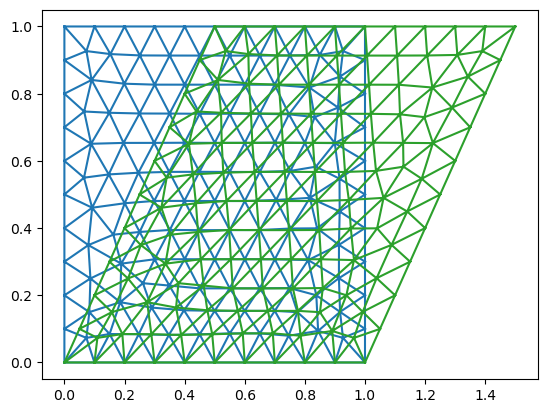

In [11]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])

In [12]:
print(S.node_coords[S.S[2][42]])
print(S.node_coords[S.S[2][43]])
print(S.dual_volumes[0][1])
print(0.5*S.primal_volumes[2][42] + 0.5*S.primal_volumes[2][43])
print(S.primal_volumes[2][43])

[[0.24613965 0.56475852 0.        ]
 [0.14750647 0.55968916 0.        ]
 [0.20061255 0.47388352 0.        ]]
[[0.24613965 0.56475852 0.        ]
 [0.29894171 0.48078198 0.        ]
 [0.34887324 0.56725585 0.        ]]
0.002141016151373649
0.004372893127799972
0.0043795379789686355


In [13]:
#print(ela.obj_linear_elasticity_energy(curr_node_coords, f, gamma, boundary_values, ext_forces_coeffs))
#print(ela.obj_linear_elasticity_energy(true_curr_node_coords, f, gamma, boundary_values, ext_forces_coeffs))

In [15]:
#print(true_curr_node_coords)
#print(curr_node_coords)
#print(true_curr_node_coords)
#print(curr_node_coords)
err = np.linalg.norm(sol-true_curr_node_coords.flatten())**2
print(err)
print(np.allclose(true_curr_node_coords, curr_node_coords, atol=1e-8))

2.502198944537047e-14
True
